In [1]:
from ResNet_cifar10 import BasicBlock, Bottleneck, MyResNet

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from torch.utils.data import DataLoader
from torch.utils.data import sampler

import torchvision.datasets as dset
import torchvision.transforms as T

import matplotlib.pyplot as plt
import numpy as np

In [3]:
# GPU
def Device():
    if torch.cuda.is_available():
        device = torch.device('cuda')
    else:
        device = torch.device('cpu')
    return device

In [10]:
# load data
def Load_Data():
    NUM_TRAIN = 49000

    transform_train = T.Compose([
                    T.RandomCrop(size=32,padding=4),
                    T.RandomHorizontalFlip(),
                    T.ToTensor(),
                    T.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
                ])

    transform = T.Compose([
                    T.ToTensor(),
                    T.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
                ])

    cifar10_train = dset.CIFAR10('./datasets', train=True, download=True, transform=transform_train)
    loader_train = DataLoader(cifar10_train, batch_size=128, sampler=sampler.SubsetRandomSampler(range(NUM_TRAIN)))

    cifar10_val = dset.CIFAR10('./datasets', train=True, download=True, transform=transform)
    loader_val = DataLoader(cifar10_val, batch_size=128, sampler=sampler.SubsetRandomSampler(range(NUM_TRAIN, 50000)))

    cifar10_test = dset.CIFAR10('./datasets', train=False, download=True, transform=transform)
    loader_test = DataLoader(cifar10_test, batch_size=128)

    return loader_train, loader_val, loader_test

In [11]:
loss_history = []
accuracy_train_history = []
accuracy_val_history = []
device = Device()
loader_train, loader_val, loader_test = Load_Data()

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


In [8]:
# Accuracy
def Check_Accuracy(loader, model):
    if loader.dataset.train:
        print("Accuracy on Validation Set: ")
    else:
        print("Accuracy on Test Set: ")
    correct = 0
    total = 0
    with torch.no_grad():
        for x,y in loader:
            x = x.to(device, dtype = torch.float32)
            y = y.to(device, dtype = torch.long)

            scores = model(x)
            _, predict = torch.max(scores, 1)
            correct += (predict == y).sum()
            total += predict.size(0)
        accuracy = correct / total
        accuracy_val_history.append(accuracy)
        print('{:.2%}'.format(accuracy))

In [12]:
# Train
def Train(model, optimizer, epochs = 1):
    criterion = nn.CrossEntropyLoss().to(device)
    model = model.to(device = device)
    model.train() # setup for BN
    for e in range(epochs):
        print('Epoch(%d)' % e)
        for t,(x,y) in enumerate(loader_train):
            x = x.to(device, dtype = torch.float32)
            y = y.to(device, dtype = torch.long)

            scores = model(x)
            optimizer.zero_grad()
            loss = criterion(scores, y)
            loss.backward()
            optimizer.step()
            
            correct = 0
            total = 0
            _, predict = torch.max(scores, 1)
            correct += (predict == y).sum()
            total += predict.size(0)
            accuracy_train_history.append(correct/total)

            if t % 100 == 0:
                print('Loss: %.4f' % loss)
                loss_history.append(loss)
                Check_Accuracy(loader_val, model)
                print()


In [13]:
def Draw():
    plt.xlabel('n')
    plt.ylabel('loss')
    n = np.arange(1, len(loss_history) + 1)
    m = np.arange(1, len(accuracy_val_history) + 1)
    k = np.arange(1, len(accuracy_train_history) + 1) / 100
    plt.plot(n, loss_history, color = 'g')
    plt.plot(m, accuracy_val_history, color = 'r')
    plt.plot(k, accuracy_train_history, color = 'b')
    plt.show()

Epoch(0)
Loss: 2.4897
Accuracy on Validation Set: 
10.20%

Loss: 2.0375
Accuracy on Validation Set: 
25.90%

Loss: 1.9039
Accuracy on Validation Set: 
29.20%

Loss: 1.6983
Accuracy on Validation Set: 
39.40%

Epoch(1)
Loss: 1.7616
Accuracy on Validation Set: 
43.30%

Loss: 1.5410
Accuracy on Validation Set: 
38.40%

Loss: 1.3096
Accuracy on Validation Set: 
44.30%

Loss: 1.3703
Accuracy on Validation Set: 
48.80%

Epoch(2)
Loss: 1.3998
Accuracy on Validation Set: 
50.70%

Loss: 1.2419
Accuracy on Validation Set: 
51.60%

Loss: 1.2316
Accuracy on Validation Set: 
55.70%

Loss: 1.1235
Accuracy on Validation Set: 
55.70%

Epoch(3)
Loss: 1.1391
Accuracy on Validation Set: 
60.30%

Loss: 1.1330
Accuracy on Validation Set: 
60.00%

Loss: 1.2360
Accuracy on Validation Set: 
61.60%

Loss: 0.9398
Accuracy on Validation Set: 
61.90%

Epoch(4)
Loss: 0.8993
Accuracy on Validation Set: 
63.20%

Loss: 0.9707
Accuracy on Validation Set: 
64.50%

Loss: 0.9632
Accuracy on Validation Set: 
60.40%

Loss:

TypeError: can't convert cuda:0 device type tensor to numpy. Use Tensor.cpu() to copy the tensor to host memory first.

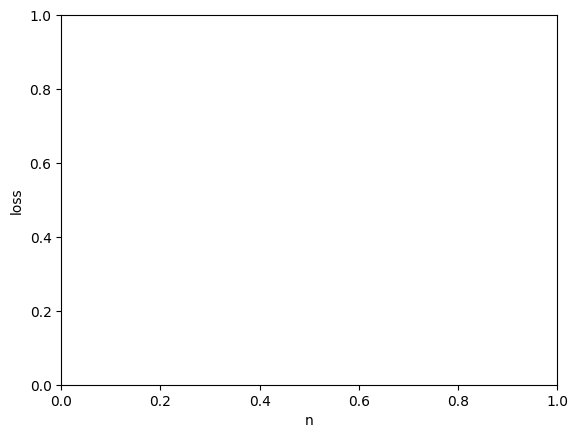

In [14]:
learning_rate = 1e-1
model = MyResNet(BasicBlock, [3,4,6,3], 10)
optimizer = optim.SGD(model.parameters(), lr=learning_rate, 
                    momentum=0.9, weight_decay=1e-4)
# optimizer = optim.Adam(model.parameters(), lr=learning_rate)
Train(model, optimizer, epochs = 20)
Draw()